# Analysis of 精度公式


$$ 精度公式(P_p, P_m) = 1-2\sum_{i=1}^N\left(\left|\frac{P_{p,i}}{P_{p,i}+P_{m,i}}-\frac{1}{2}\right|\cdot\frac{| P_{p,i} - P_{m,i}|}{\sum_{j=0}^N|P_{p,j}-P_{m,j}|}\right)
$$


国家电网公司用这个公式检查光功率预测。我们要有预测精度比75%更多。


Let A,B,C 地方有光伏电站， 问题是: 我们可以不可以有 $f(A,B)\mapsto C$ ?
Let Acc

$$ Acc(f) := \sum_{d\in D}\phi\left(精度公式\left(f(A_d, B_d), C_d\right)\right)$$

$$  \phi (x) = 
\begin{cases}
1 &\mbox{如果 } x\geq75\% \\
0 &\mbox{如果 } x<75\%
\end{cases}  $$

我们要用人工神经网络，不过因为$\phi$不是可导数(derivable)所以我们必须用:

$$\lambda_i:x\mapsto[0,1]$$
$$\lim_{i\to\infty}\lambda_i\to\phi$$


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_style("whitegrid")
from pvlib.location import Location

import keras
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K

## Data

地方A,B需要在C的环境,因此他们的电值进行可能好像C的。不过他们太近的话，预测就太好了。太好的预测可能做artifcts。

Text(0, 0.5, 'Power [kW]')

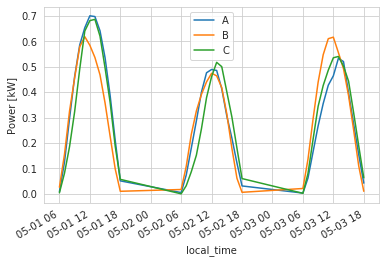

In [2]:
df = pd.DataFrame()

#df["A"] = pd.read_csv("ninja_pv_26.3774_106.0674_uncorrected.csv", comment="#").set_index("local_time").electricity
#df["B"] = pd.read_csv("ninja_pv_26.6595_107.1326_uncorrected.csv", comment="#").set_index("local_time").electricity

df["A"] = pd.read_csv("ninja_pv_24.4920_108.5734_uncorrected.csv", comment="#").set_index("local_time").electricity
df["B"] = pd.read_csv("ninja_pv_23.1669_114.4629_uncorrected.csv", comment="#").set_index("local_time").electricity

df["C"] = pd.read_csv("ninja_pv_26.6745_106.4161_uncorrected.csv", comment="#").set_index("local_time").electricity
df = df.set_index(pd.DatetimeIndex(df.index))

# remove nights!
df = df[(df > 0).any(axis=1)]

df.loc["2019-05-01":"2019-05-03"].plot()
plt.ylabel("Power [kW]")

0.7477868671873343


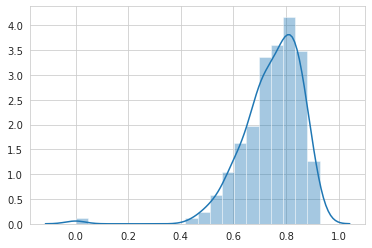

In [3]:
def 精度公式(p, m):
    frac_sum = np.abs(p-m).sum()
    return 1 - 2 * (np.abs(p / (p+m) - 0.5) * (np.abs(p-m)/frac_sum)).sum()

f = lambda tmp : (tmp.A + tmp.B).values / 2

# full dataset
result = df.groupby(df.index.strftime("%Y-%m-%d")).apply(
    lambda tmp:精度公式(f(tmp), tmp.C))
    #lambda tmp: np.sqrt(((f(tmp) - tmp.C.values)**2).mean()))
    
# half dataset
result = df.iloc[int(len(df)/2):].groupby(df.iloc[int(len(df)/2):].index.strftime("%Y-%m-%d")).apply(
    lambda tmp:精度公式(f(tmp), tmp.C))
    #lambda tmp: np.sqrt(((f(tmp) - tmp.C.values)**2).mean()))

    
sns.distplot(result)
print(result.mean())

## Keras (人工神经网络)

写Keras $f$有精度公式和$\lambda_i,\phi$。
因为我们不可以用$\phi$为training,所以training会有$\lambda_i$，evaluation会有$\phi$。

In [ ]:
def custom_loss(y_true, y_pred):
    """ RMSE """
    loss = K.mean(((y_true - y_pred)**2))
    loss = K.sqrt(loss)
        
    return loss
  
def create_model():
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(100))
    model.add(keras.layers.Dense(50))
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.Dense(1))
    
    model.compile(loss=custom_loss, optimizer='adam')
    return model

model = KerasRegressor(
    build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# Train on full dataset
#train = model.fit(df[["A","B"]].values, df.C.values)

# Train on half of dataset
train = model.fit(df.iloc[:int(len(df)/2)][["A","B"]].values, df.iloc[:int(len(df)/2)].C.values)



plt.plot(train.history["loss"])
plt.ylabel("Loss")
plt.xlabel("Iterations")

如果预测有零下值进行，精度公式有错误。

In [ ]:
def func(*args, **kwargs):
    retval = model.predict(*args, **kwargs)
    retval[retval < 0] = 0
    return retval
    
model.fix_predict = func

In [ ]:
plt.scatter(model.predict(df[["A", "B"]].values), df.C.values)

In [ ]:
tmp = df.loc["2019-10-09"]

plt.plot(model.fix_predict(tmp[["A", "B"]].values),
         label="keras: %.3f" % 精度公式(model.fix_predict(tmp[["A", "B"]].values), tmp.C.values))

plt.plot(f(tmp[["A", "B"]]),
         label="mean: %.3f" % 精度公式(f(tmp[["A", "B"]]), tmp.C.values))


plt.plot(tmp.C.values, label="truth")
plt.legend()

In [ ]:
# Evaluate on full dataset
result = df.groupby(df.index.strftime("%Y-%m-%d")).apply(
    lambda tmp:精度公式(model.fix_predict(tmp[["A", "B"]].values), tmp.C))
    #lambda tmp: np.sqrt(((model.predict(tmp[["A", "B"]].values) - tmp.C.values)**2).mean()))
    
# Evaluate on hald dataset
result = df.iloc[int(len(df)/2):].groupby(df.iloc[int(len(df)/2):].index.strftime("%Y-%m-%d")).apply(
    lambda tmp:精度公式(model.fix_predict(tmp[["A", "B"]].values), tmp.C))
    #lambda tmp: np.sqrt(((model.predict(tmp[["A", "B"]].values) - tmp.C.values)**2).mean()))

    
sns.distplot(result)
print(result.mean())

## $ \lambda_i \to \phi$ 

## Result & Outlook